In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.utils import feasible_mode_sequences
from pympc.plot import plot_input_sequence, plot_state_trajectory

In [2]:
# numeric parameters
m = 1.
d = .5
r = .1
eps = .5
h = .01
x_max = np.array([d-r, 5.])
x_min = - x_max
u_max = np.array([5.])
u_min = - u_max
xu_max = np.concatenate((x_max, u_max))
xu_min = np.concatenate((x_min, u_min))

In [3]:
q, v= sp.symbols('q v')
x = sp.Matrix([q, v])
f = sp.symbols('f')
u = sp.Matrix([f])
xu = x.col_join(u)

In [4]:
# mode 1: no contact
v_next = v + h*f/m
q_next = q + h*v
x_next = sp.Matrix([q_next, v_next])
S1 = LinearSystem.from_symbolic(x, u, x_next)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu,sp.Matrix([q + v*h + - d + r,- q - v*h - d + r]))

In [5]:
# mode 2: right wall
x_next = sp.Matrix([q, -eps*v])
S2 = AffineSystem.from_symbolic(x, u, x_next)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu,sp.Matrix([- q - v*h + d - r]))

In [6]:
# mode 3: left wall
x_next = sp.Matrix([q, -eps*v])
S3 = AffineSystem.from_symbolic(x, u, x_next)
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu,sp.Matrix([q + v*h + d - r]))

In [7]:
S = PieceWiseAffineSystem([S1, S2, S3], [D1, D2, D3])
print S.is_well_posed()

True


In [8]:
for T in range(1,6):
    f_ms = feasible_mode_sequences(S,T)[0]
    n_ft = len(f_ms)
    print '\nfeasible transitions', n_ft
    print 'cont. var./T', (S.nx*(T+1)*n_ft + S.nu*T*n_ft)/float(T)
    print 'bin. var./T', n_ft/float(T)
    print 'equalities/T', (S.nx*T*n_ft + S.nx*(T+1) + S.nu*T + 1)/float(T)
    print 'inequalities/T', (sum(sum(S.domains[i].A.shape[0] for i in ms[0]) for ms in f_ms))/float(T)
    print 'complexity', n_ft**(1/float(T))


feasible transitions 3
cont. var./T 15.0
bin. var./T 3.0
equalities/T 12.0
inequalities/T 22.0
complexity 3.0

feasible transitions 5
cont. var./T 20.0
bin. var./T 2.5
equalities/T 14.5
inequalities/T 38.0
complexity 2.2360679775

feasible transitions 9
cont. var./T 33.0
bin. var./T 3.0
equalities/T 22.0
inequalities/T 68.6666666667
complexity 2.08008382305

feasible transitions 15
cont. var./T 52.5
bin. var./T 3.75
equalities/T 33.75
inequalities/T 115.0
complexity 1.96798967127

feasible transitions 25
cont. var./T 85.0
bin. var./T 5.0
equalities/T 53.6
inequalities/T 192.0
complexity 1.90365393872


[array([0., 0.]), array([0.  , 0.05])]
True


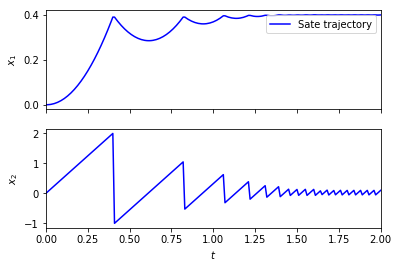

In [9]:
x0 = np.array([0., 0.])
u0 = np.array([5.])
print S1.simulate(x0, [u0])
print D1.contains(np.concatenate((x0, u0)))
x_sim, ms_sim = S.simulate(x0, [u0]*200)
plot_state_trajectory(x_sim, h)

In [19]:
N = 60
Q = np.diag([1., 1.])*h
R = np.diag([1.])*h
P = Q
X_N = Polyhedron.from_bounds(np.zeros(S.nx),np.zeros(S.nx))
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'PF', 'two')

In [20]:
x0 = np.array([0.,2.5])
u_opt, x_opt, ms_opt, cost_opt = controller.feedforward(x0)
print 'optimal cost:', cost_opt

solution time: 0.556477069855
optimal cost: 3.10433538054


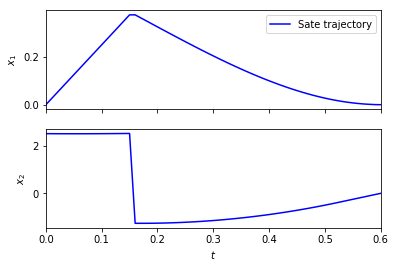

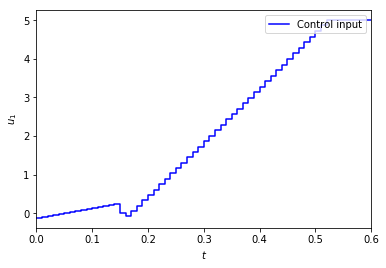

In [16]:
plot_state_trajectory(x_opt, h)
plt.show()
plot_input_sequence(u_opt, h)

In [25]:
T = 2
assert N%T == 0
S_c = S.condense_stages(T)
x0_c = np.concatenate((np.zeros((S.nx*(T-1))), x0))
Q_c = block_diag(*[Q]*T)
R_c = block_diag(*[R]*T)
P_c = block_diag(*[Q]*(T-1)+[P])
X_N_c = Polyhedron(
    np.hstack((np.zeros((X_N.A.shape[0], S.nx*(T-1))), X_N.A)),
    X_N.b
)
controller_c = HybridModelPredictiveController(S_c, N/T, Q_c, R_c, P_c, X_N_c, 'PF', 'two')
u_opt_c, x_opt_c, ms_opt_c, cost_opt_c = controller_c.feedforward(x0_c)
print 'optimal cost:', cost_opt_c

solution time: 0.215846061707
optimal cost: 3.10436930271
